In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import scipy.stats
from tqdm import tqdm

import ipywidgets as widgets

In [20]:
class SpaceNet(torch.nn.Module):
    def __init__(self, nr):
        super(SpaceNet, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.spatial_representation = torch.nn.Sequential(
            torch.nn.Linear(3, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, nr),
            torch.nn.ReLU()
        )

    def forward(self, inputs):
        p = self.spatial_representation(inputs) # ns, nr
        corr = p@p.T # correlation matrix
        return p, corr

In [21]:
def train_step(model, inputs, r, c, scale = 0.2):
    p, corr = model(inputs)
    dr = torch.sum((r[:,None] - r[None])**2, dim = -1)
    dc = (c[:,None] - c[None])**2 
    
    spatial_correlation = torch.exp(-0.5/scale**2*dr)
    context_correlation = torch.exp(-0.5/scale**2*dc)
    correlation_loss = (corr - spatial_correlation*context_correlation)**2
    return torch.mean(correlation_loss)

In [22]:
train_steps = 10000

nr = 100 # no. of spatial representations
bs = 512 # batch size

model = SpaceNet(nr)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    optimizer.zero_grad()
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32)
    c = torch.tensor(np.random.uniform(-1, 1, bs), dtype = torch.float32)
    inputs = torch.cat((r, c[:,None]), dim = -1)
    loss = train_step(model, inputs, r, c)

    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        loss = loss.item()
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.002085: 100%|██████████| 10000/10000 [01:03<00:00, 157.69it/s]


Text(0, 0.5, 'Train Loss')

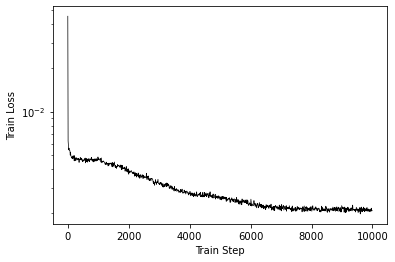

In [23]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [24]:
# evaluate on 2x2 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)

In [77]:
n_show = 5   # show ratemaps for first n_show nodes
cols = np.linspace(0,1, nr)

def f(c):
    fig, ax = plt.subplots(1, n_show + 1, figsize = (10, 5))
    context = c*torch.tensor(np.ones(len(u)), dtype = torch.float32)
    inputs = torch.cat((u, context[...,None]), dim = -1)
    p, pcorr = model(inputs)
    p = p.detach().numpy()
    max_ind = np.argmax(p, axis = 0) 
    max_loc = u[max_ind]
    mask = np.array([p[ind, i] > 0 for i, ind in enumerate(max_ind)])
    ax[0].set_title(f"Non-zero units: {mask.sum()}")

    ax[0].scatter(*max_loc.T, c = cols, cmap = "jet")
    ax[0].axis([-1, 1, -1, 1])
    ax[0].set_aspect("equal")
    
    for i in range(1, n_show + 1):
        ax[i].imshow(p[:,i-1].reshape((n,n)))
        ax[i].axis("off")
    plt.show()
    
c_slider = widgets.FloatSlider(
    value=0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description='c:',
    readout_format='.2f')

widgets.interactive(f, c = c_slider)

interactive(children=(FloatSlider(value=0.0, description='c:', max=1.0, min=-1.0, step=0.01), Output()), _dom_…